# Вчитување на податоците од csv фајловите и нивно сумаризирање според песна

In [1]:
import matplotlib.pyplot as plt
import numpy as np
#sumariziranje na podatocite od charts:
import pandas as pd
import seaborn as sns
# import fbprophet
from sklearn.manifold import TSNE
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.mixture import GaussianMixture
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set()

C:\Users\PeckuBre\.conda\envs\isproekt\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
songs={}
chart_csv=pd.read_csv("data_uk_all.csv")
for ind, row in chart_csv.iterrows():
    song_data=dict(row)
    song_data.pop("week")
    song_data.pop("chart_position")
    song_data.pop('weeks_on_chart')
    if row['title'] not in songs:
        #key=koja nedela e na charts, value e koja pozicija e
        chart_info={row['weeks_on_chart']:row['chart_position']}
        song_data['chart_info']=chart_info
        songs[row['title']]=song_data
    else:
        song=songs[row['title']]
        song['chart_info'][row['weeks_on_chart']]=row['chart_position']        

for song in songs.values():
#     print(song)
    chart_info=song['chart_info']
    tmp=dict(map(lambda x:(int(x[0]),float(x[1])),sorted(chart_info.items())))
    song['chart_info']=tmp

song_features=pd.read_csv('spotify_tracks.csv')
song_features.drop(columns=['uri','track_href','type'])

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,analysis_url,duration_ms,time_signature,title,artist
0,0,0.719,0.704,1,-4.724,1,0.0476,0.06910,0.000000,0.1660,0.628,133.002,25sgk305KZfyuqVBQIahim,https://api.spotify.com/v1/audio-analysis/25sg...,187436,4,SWEET BUT PSYCHO,AVA MAX
1,1,0.717,0.653,1,-5.634,1,0.0658,0.22900,0.000000,0.1010,0.412,106.966,3e9HZxeyfWwjeyPAMmWSSQ,https://api.spotify.com/v1/audio-analysis/3e9H...,207320,4,THANK U NEXT,ARIANA GRANDE
2,2,0.601,0.794,7,-5.844,0,0.0671,0.00987,0.000001,0.3880,0.244,114.066,27rdGxbavYJeBphck5MZAF,https://api.spotify.com/v1/audio-analysis/27rd...,217467,4,NOTHING BREAKS LIKE A HEART,MARK RONSON FT MILEY CYRUS
3,3,0.829,0.539,11,-7.359,0,0.2080,0.13600,0.000002,0.1030,0.388,99.960,7xQAfvXzm3AkraOtGPWIZg,https://api.spotify.com/v1/audio-analysis/7xQA...,149547,4,WOW.,POST MALONE
4,4,0.760,0.479,2,-5.574,1,0.0466,0.55600,0.000000,0.0703,0.913,89.911,3KkXRkHbMCARz0aVfEt68P,https://api.spotify.com/v1/audio-analysis/3KkX...,158040,4,SUNFLOWER,POST MALONE FT SWAE LEE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,688,0.671,0.529,0,-7.226,1,0.3070,0.07690,0.000335,0.0856,0.203,161.989,4VXIryQMWpIdGgYR4TrjT1,https://api.spotify.com/v1/audio-analysis/4VXI...,165820,4,ALL GIRLS ARE THE SAME,JUICE WRLD
689,689,0.314,0.286,10,-10.191,1,0.0350,0.93500,0.025800,0.0999,0.278,172.021,3DDGhkxq3FeUorZppSgeLE,https://api.spotify.com/v1/audio-analysis/3DDG...,208154,4,SOMEWHERE ONLY WE KNOW,LILY ALLEN
690,690,0.596,0.894,0,-5.407,1,0.0265,0.00878,0.006590,0.1040,0.572,132.994,36PQh1G6h7n9VWB799fXpI,https://api.spotify.com/v1/audio-analysis/36PQ...,260387,5,DARLING,D-BLOCK EUROPE
691,691,0.594,0.798,4,-5.244,1,0.0844,0.11500,0.000000,0.1430,0.381,142.049,1Knctxx9vGZxpZfF66BIEa,https://api.spotify.com/v1/audio-analysis/1Knc...,191840,4,LEGENDS,JUICE WRLD


Приказ на позициите со тек на време. Секоја точка од x-оската е 1 недела, а y-оската е позицијата на топ листата.

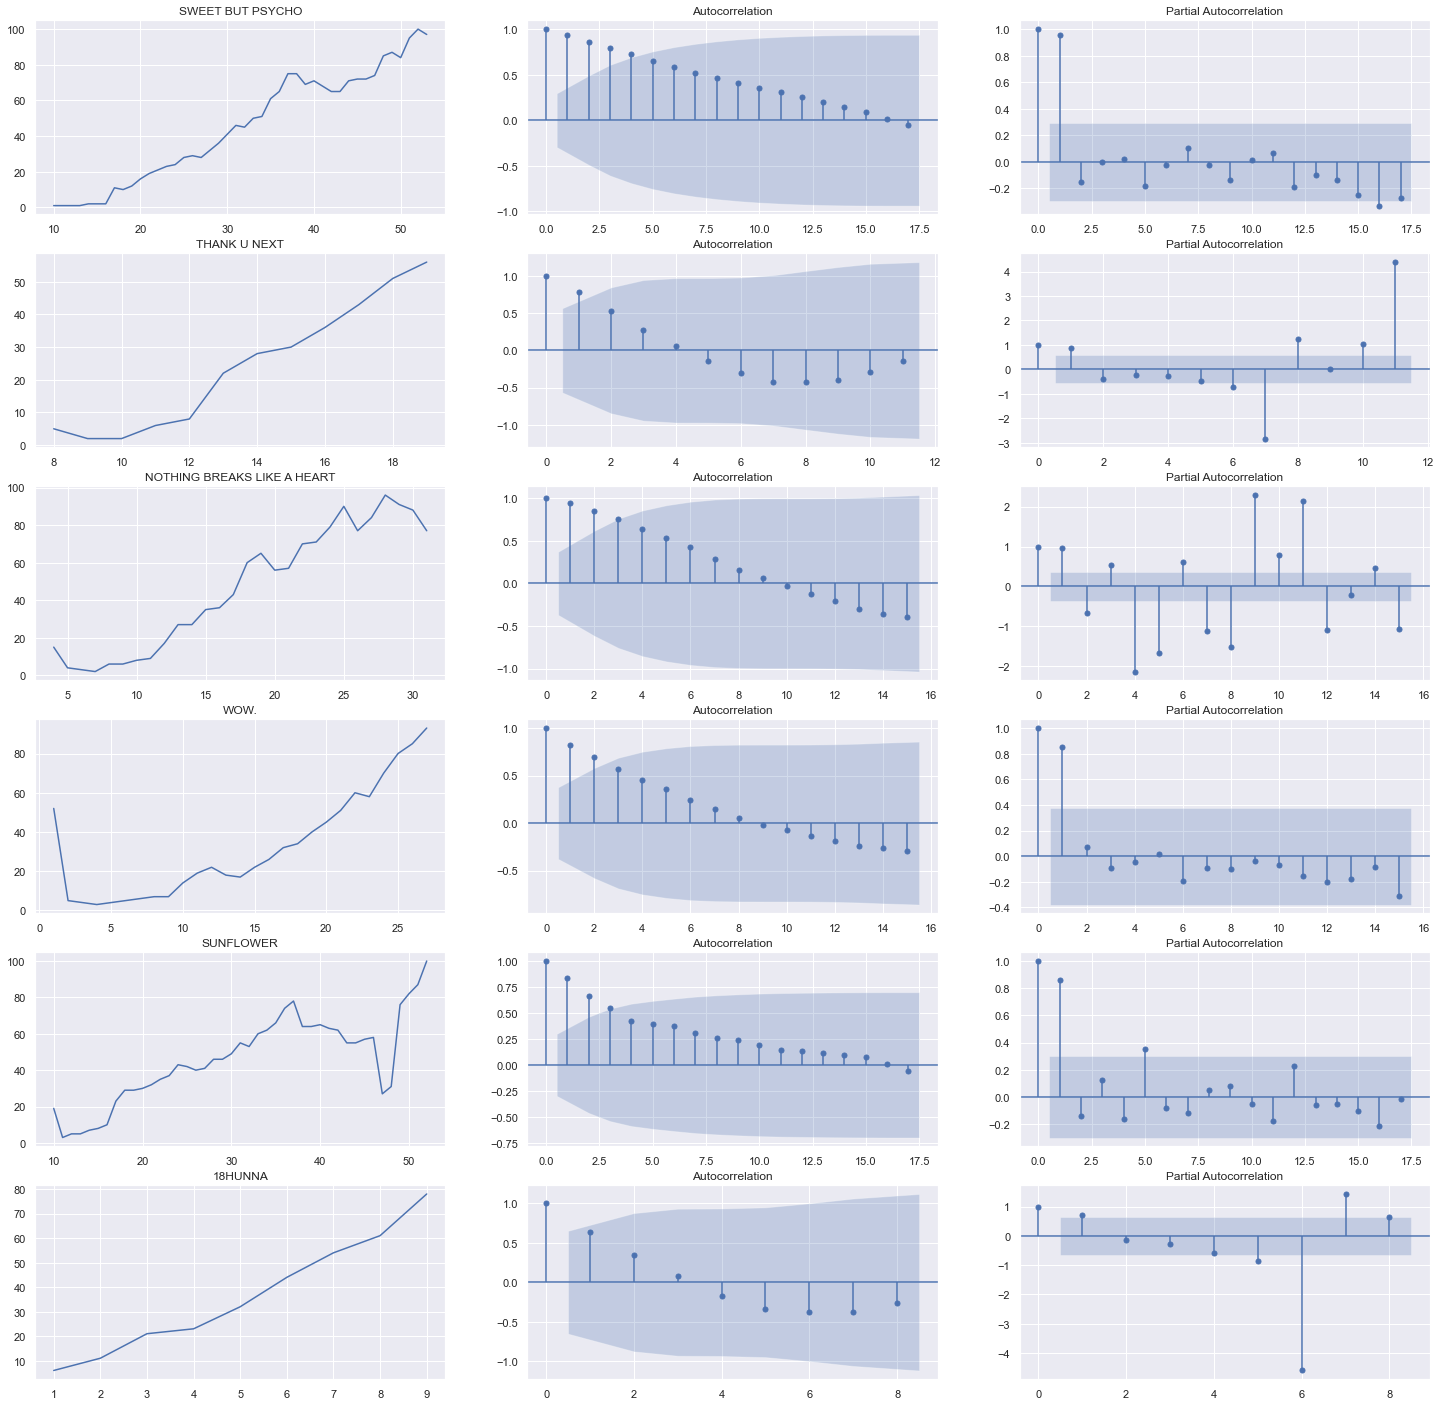

In [3]:
fig,axes=plt.subplots(6,3,figsize=(25,25))
i=0
for song in list(songs.values())[:6]:
#     plt.subplot(6,2,i)
    
#     plt.title(song['title'])
    weeks=np.array(list(song['chart_info'].keys()))
    positions=np.array(list(song['chart_info'].values())) 
    axes[i,0].plot(weeks,positions)
    axes[i,0].set_title(song['title'])
    plot_acf(positions,ax=axes[i,1])
    plot_pacf(positions,ax=axes[i,2])
    i+=1   

Податоците се автокорелирани, па за да можеме да го примениме ARIMA моделот врз нив, треба да го сведеме случајниот процес на блиску стационарен. Тоа може да се оствари со диференцирање.
Приказ на првиот диференцијал и автокорелацијата:

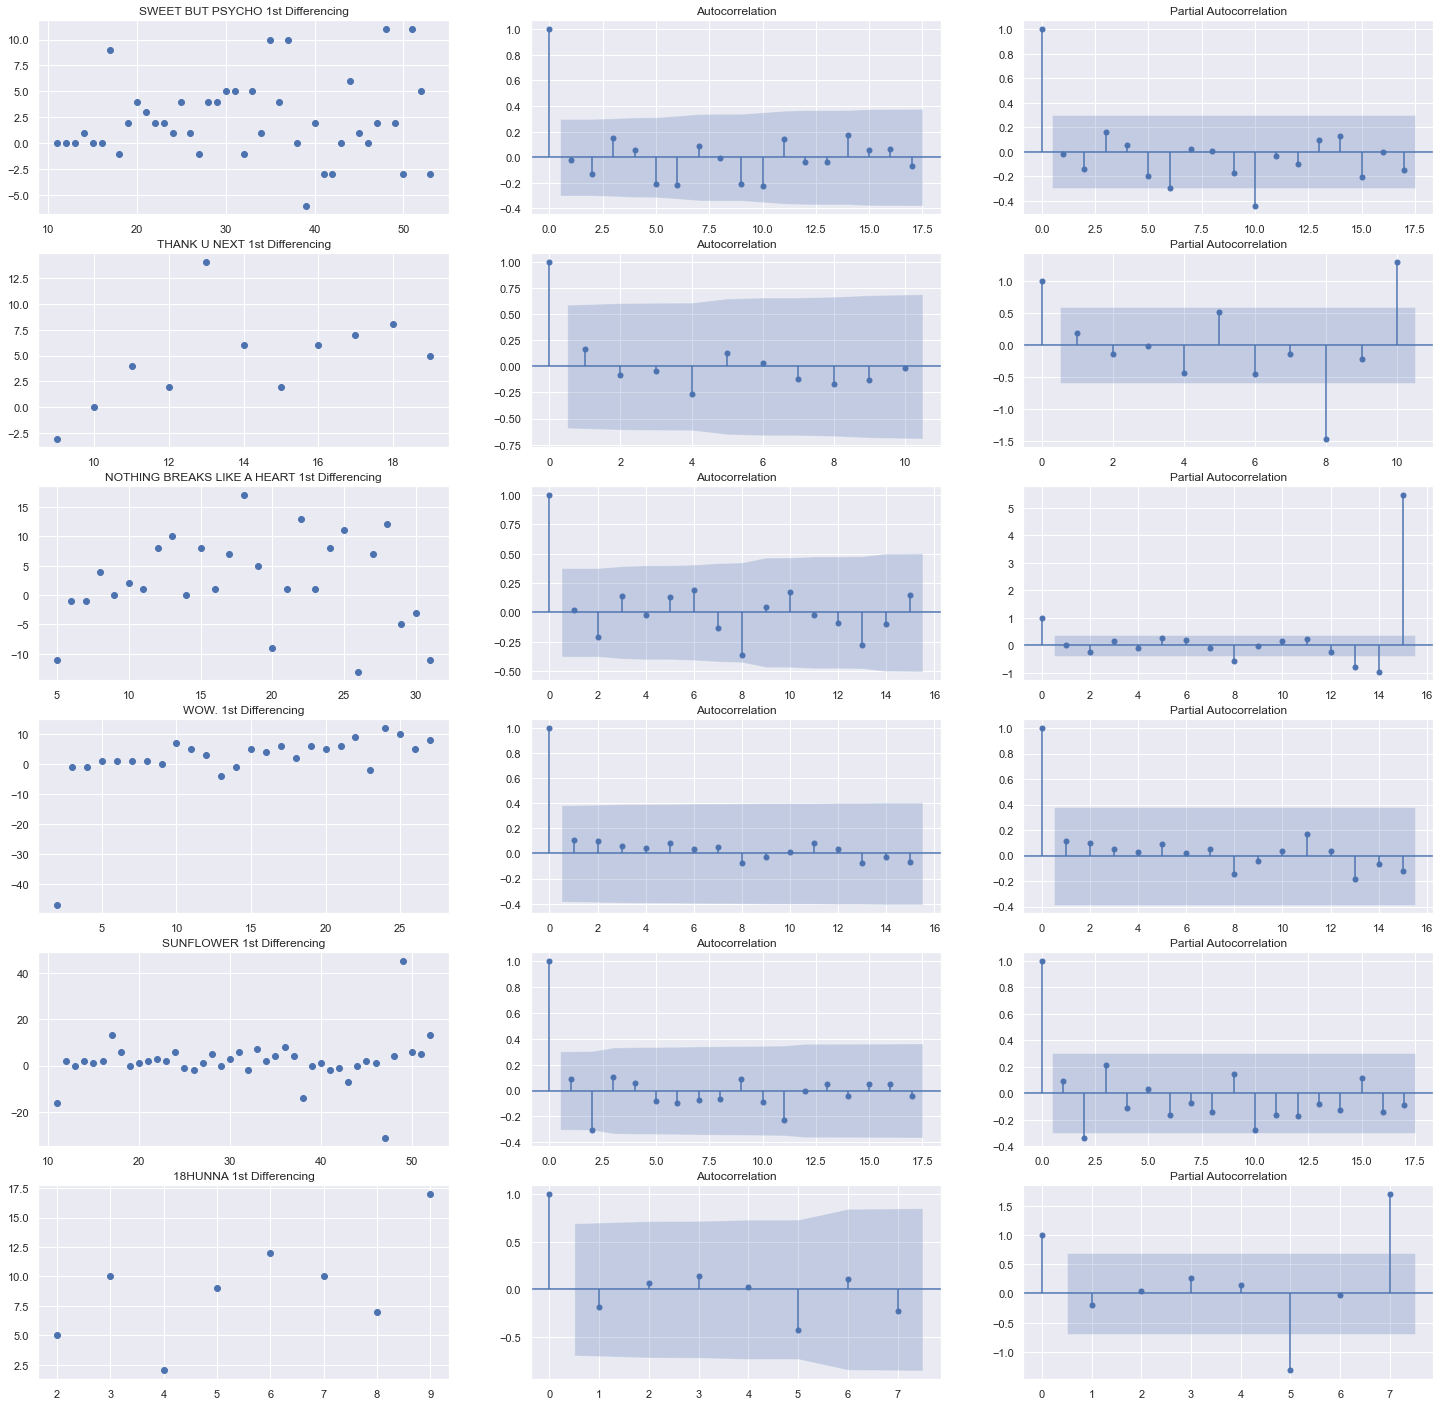

In [4]:
fig,axes=plt.subplots(6,3,figsize=(25,25))
i=0
for song in list(songs.values())[:6]:
#     plt.subplot(6,2,i)
    
#     plt.title(song['title'])
    weeks=np.array(list(song['chart_info'].keys()))
    positions=np.array(list(song['chart_info'].values()))
    #prvi diferencijali:
    diff1=np.diff(positions,1)  
    axes[i,0].scatter(weeks[1:],diff1)
    axes[i,0].set_title(song['title']+' 1st Differencing')
    plot_acf(diff1,ax=axes[i,1])
    plot_pacf(diff1,ax=axes[i,2])
    i+=1
#     plot_acf()
#     diff2=np.diff(diff1,1)    
#     plt.scatter(weeks[2:],diff2)    

Според овие графици, првото диференцирање е доволно за да се отстрани автокорелацијата. Можеме да продолжиме со ARIMA моделот за предвидување на следните позиции на топ листата.

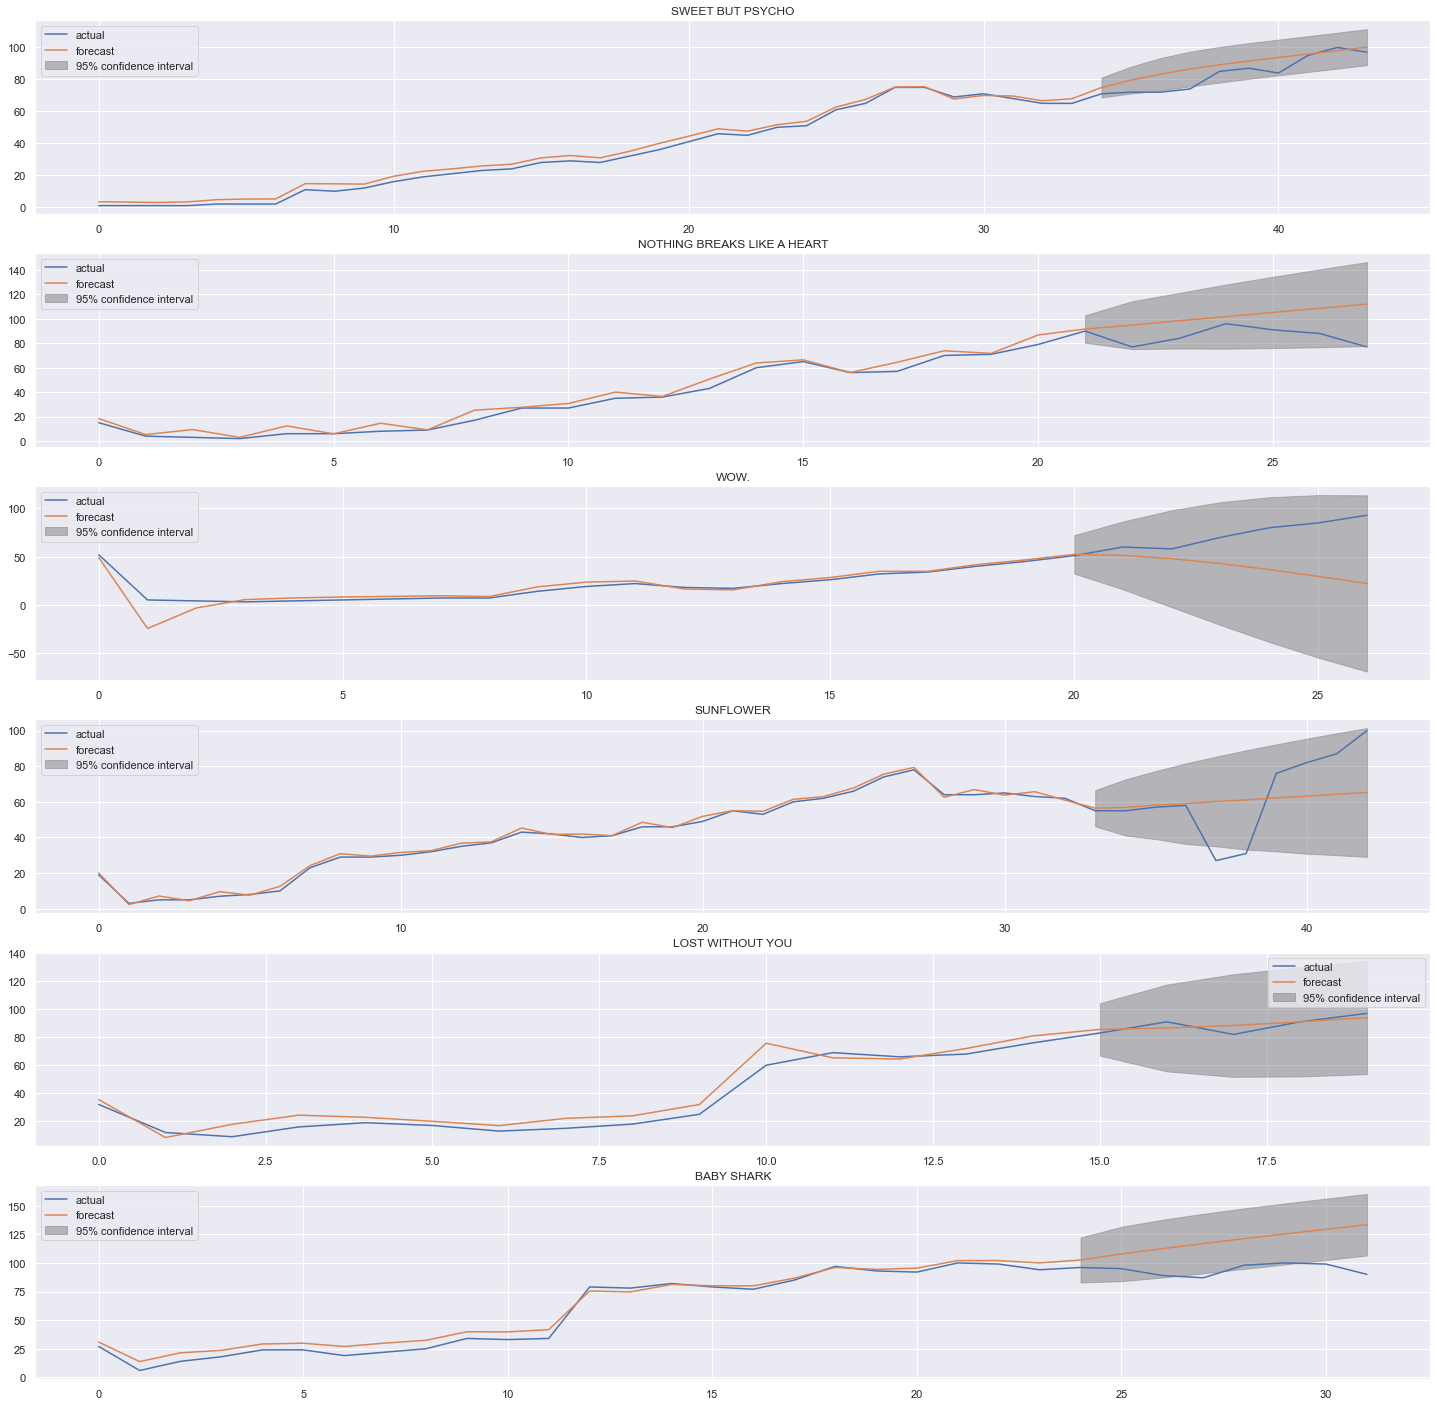

In [5]:
fig,axes=plt.subplots(6,1,figsize=(25,25))
i=0
for song in list(songs.values())[:15]:
    weeks=np.array(list(song['chart_info'].keys()))
    if(len(weeks)<20):
        continue
    positions=np.array(list(song['chart_info'].values()))
    x_train=range(1,int(len(weeks)*0.8))
    x_test=range(1,len(weeks))
    y_train=positions[:int(len(weeks)*0.8)]
    model=ARIMA(y_train,order=(3,1,1))
    model_fit=model.fit()
#     print(model_fit.summary())
    axes[i].plot(positions,label='actual')
    axes[i].set_title(song['title'])
    model_fit.plot_predict(start=1,end=len(weeks),ax=axes[i],plot_insample=False)
#     axes[i].plot(positions,color='red')
#     predictions=model_fit.forecast(int(len(weeks)*0.2))[0]
#     axes[i].plot(range(floor(len(weeks)*0.8)-2,len(weeks)-2),predictions,color='blue')
    i+=1

Би рекол дека моделот не е толку лош во предвидување, но проблемот е што за некои песни немаме многу податоци кога се нови на листата и не можеме да го предвидиме нивното однесување. Покрај тоа овој модел не е корисен бидејќи многу лесно може да се предвиди трендот на некоја песна.

In [6]:
only_features=song_features[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]
song_features.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,title,artist
0,0,0.719,0.704,1,-4.724,1,0.0476,0.06910,0.000000,0.1660,...,133.002,audio_features,25sgk305KZfyuqVBQIahim,spotify:track:25sgk305KZfyuqVBQIahim,https://api.spotify.com/v1/tracks/25sgk305KZfy...,https://api.spotify.com/v1/audio-analysis/25sg...,187436,4,SWEET BUT PSYCHO,AVA MAX
1,1,0.717,0.653,1,-5.634,1,0.0658,0.22900,0.000000,0.1010,...,106.966,audio_features,3e9HZxeyfWwjeyPAMmWSSQ,spotify:track:3e9HZxeyfWwjeyPAMmWSSQ,https://api.spotify.com/v1/tracks/3e9HZxeyfWwj...,https://api.spotify.com/v1/audio-analysis/3e9H...,207320,4,THANK U NEXT,ARIANA GRANDE
2,2,0.601,0.794,7,-5.844,0,0.0671,0.00987,0.000001,0.3880,...,114.066,audio_features,27rdGxbavYJeBphck5MZAF,spotify:track:27rdGxbavYJeBphck5MZAF,https://api.spotify.com/v1/tracks/27rdGxbavYJe...,https://api.spotify.com/v1/audio-analysis/27rd...,217467,4,NOTHING BREAKS LIKE A HEART,MARK RONSON FT MILEY CYRUS
3,3,0.829,0.539,11,-7.359,0,0.2080,0.13600,0.000002,0.1030,...,99.960,audio_features,7xQAfvXzm3AkraOtGPWIZg,spotify:track:7xQAfvXzm3AkraOtGPWIZg,https://api.spotify.com/v1/tracks/7xQAfvXzm3Ak...,https://api.spotify.com/v1/audio-analysis/7xQA...,149547,4,WOW.,POST MALONE
4,4,0.760,0.479,2,-5.574,1,0.0466,0.55600,0.000000,0.0703,...,89.911,audio_features,3KkXRkHbMCARz0aVfEt68P,spotify:track:3KkXRkHbMCARz0aVfEt68P,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,https://api.spotify.com/v1/audio-analysis/3KkX...,158040,4,SUNFLOWER,POST MALONE FT SWAE LEE


In [7]:
song_features.describe()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000
mean,346.000000,0.658612,0.627664,5.329004,-6.785887,0.597403,0.129972,0.253423,0.023690,0.170481,0.474879,121.146945,203711.949495,3.959596
std,200.196154,0.157954,0.183288,3.592097,3.171278,0.490775,0.122810,0.269508,0.119479,0.128179,0.214997,28.731443,45811.105945,0.392982
min,0.000000,0.000000,0.002930,0.000000,-40.279000,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,7229.000000,0.000000
25%,173.000000,0.567000,0.527000,2.000000,-7.917000,0.000000,0.042300,0.042500,0.000000,0.095100,0.324000,99.960000,177186.000000,4.000000
50%,346.000000,0.672000,0.646000,6.000000,-6.245000,1.000000,0.075200,0.140000,0.000000,0.122000,0.460000,120.029000,200680.000000,4.000000
75%,519.000000,0.768000,0.757000,8.000000,-4.930000,1.000000,0.184000,0.392000,0.000025,0.202000,0.632000,140.022000,224360.000000,4.000000
max,692.000000,0.975000,0.985000,11.000000,-0.783000,1.000000,0.768000,0.990000,0.938000,0.923000,0.967000,220.099000,571345.000000,5.000000


Ќе се обидеме да идентификуваме некои кластери. Податоците ќе ги визуелизирање со помош на неколку техники за намалување на димензионалноста како T-SNE (само за визуелизација) а потоа можеме да работиме и со LDA.

In [8]:
tsne=TSNE(n_components=2,verbose=1,perplexity=20,random_state=0)
tsne_results=tsne.fit_transform(only_features)
# tsne_results[:5]

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.003s...
[t-SNE] Computed neighbors for 693 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 2.624385
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.102142
[t-SNE] KL divergence after 1000 iterations: 0.462571


<AxesSubplot:>

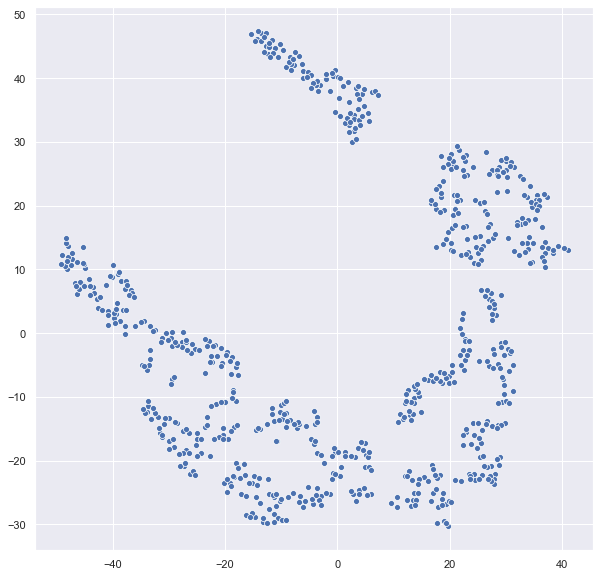

In [9]:
plt.figure(figsize=(10,10))
sns.scatterplot(tsne_results[:,0],tsne_results[:,1])

По неколку обиди за наогање на најдобриот параметар за perplexity,  јасно можеме да забележиме кластери во податоците, што беше очекувано. Секој од овие кластери би требало да репрезентира некој жанр на музика, а точките што се наогаат на граница може да се некои песни мешавини од нив.

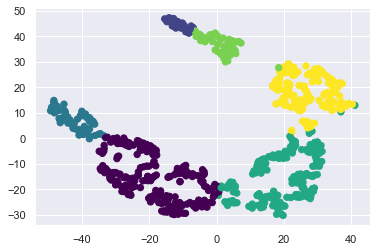

In [22]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm,labels, data, label=True, ax=None):
    ax = ax or plt.gca()
    if label:
        ax.scatter(data[:, 0], data[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(data[:, 0], data[:, 1], s=40, zorder=2)
    ax.axis('equal')


from sklearn.cluster import KMeans
kmeans = KMeans(6, random_state=0)
labels = kmeans.fit(only_features).predict(only_features)
# tsne=TSNE(n_components=2,verbose=1,perplexity=20,random_state=0)
# tsne_results=tsne.fit_transform(only_features)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, s=40, cmap='viridis');

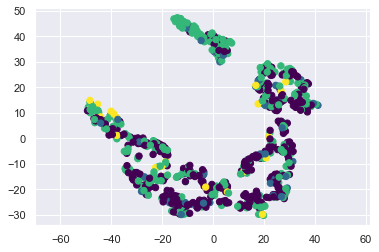

In [23]:
gmm = GaussianMixture(n_components=4, random_state=42)
labels=gmm.fit(only_features).predict(only_features)
plot_gmm(gmm,labels, tsne_results)